In [1]:
import sympy as sm
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import timeit

In [2]:
def RCP (t, u, r1, q1, aC1, eC1, hC1, mC1, aP1, eP1, mP1, hP1): 
              
    du = np.zeros([4, 1])
    
    #variables
    R = u[0]
    C = u[1]
    P = u[2]

    
    du[0] = r1*R*(1 - (R*q1)) - (aC1*R*C)/(1 + (aC1*hC1*R))
    du[1] = (eC1*aC1*R*C)/(1 + (aC1*hC1*R)) - (aP1*C*P)/(1+ (aP1*hP1*C)) - mC1*C
    du[2] = (eP1*aP1*C*P)/(1+ (aP1*hP1*C)) - mP1*P
    du[3] = 1
    
    du = du.reshape(4,)
    return(du)

In [8]:
##Parameter values from Latin Hypercube sampling
prs = pd.read_csv("C:/SDMS/trophic_temp/param_hycub_H2.csv")
par1 = np.array(prs)

In [3]:
r, K, aC, eC, hC, mC, aP, eP, hP, mP, q = sm.symbols('r, K, a_C, e_C, h_C, m_C, a_P, e_P, h_P, m_P,q', positive=True)
R, C, P = sm.symbols('R, C, P', negative=False)


Rdt = r*R*(1 - (R*q)) - (aC*R*C)/(1 + (aC*hC*R))
Cdt = (eC*aC*R*C)/(1 + (aC*hC*R)) - (aP*C*P)/(1+ (aP*hP*C)) - mC*C
Pdt = (eP*aP*C*P)/(1+ (aP*hP*C)) - mP*P

sm.Matrix([Rdt, Cdt, Pdt])

Matrix([
[                     -C*R*a_C/(R*a_C*h_C + 1) + R*r*(-R*q + 1)],
[-C*P*a_P/(C*a_P*h_P + 1) + C*R*a_C*e_C/(R*a_C*h_C + 1) - C*m_C],
[                           C*P*a_P*e_P/(C*a_P*h_P + 1) - P*m_P]])

In [4]:
Ms = sm.Matrix([Rdt, Cdt, Pdt])
Msv = Ms.jacobian([R, C, P])
Msv

Matrix([
[C*R*a_C**2*h_C/(R*a_C*h_C + 1)**2 - C*a_C/(R*a_C*h_C + 1) - R*q*r + r*(-R*q + 1),                                                                      -R*a_C/(R*a_C*h_C + 1),                               0],
[              -C*R*a_C**2*e_C*h_C/(R*a_C*h_C + 1)**2 + C*a_C*e_C/(R*a_C*h_C + 1), C*P*a_P**2*h_P/(C*a_P*h_P + 1)**2 - P*a_P/(C*a_P*h_P + 1) + R*a_C*e_C/(R*a_C*h_C + 1) - m_C,          -C*a_P/(C*a_P*h_P + 1)],
[                                                                               0,                          -C*P*a_P**2*e_P*h_P/(C*a_P*h_P + 1)**2 + P*a_P*e_P/(C*a_P*h_P + 1), C*a_P*e_P/(C*a_P*h_P + 1) - m_P]])

In [5]:
m00 = Msv[0,0].simplify()
m01 = Msv[0,1].simplify()
m02 = 0

m10 = Msv[1,0].simplify()
m11 = Msv[1,1].simplify()
m12 = Msv[1,2].simplify()

m20 = 0
m21 = Msv[2,1].simplify()
m22 = Msv[2,2]

Jss = sm.Matrix([[m00, m01, m02],[m10, m11, m12],[m20, m21, m22]])
Jss_val = Jss
Jss

Matrix([
[-C*a_C/(R*a_C*h_C + 1)**2 - 2*R*q*r + r,                                                                      -R*a_C/(R*a_C*h_C + 1),                               0],
[           C*a_C*e_C/(R*a_C*h_C + 1)**2, C*P*a_P**2*h_P/(C*a_P*h_P + 1)**2 - P*a_P/(C*a_P*h_P + 1) + R*a_C*e_C/(R*a_C*h_C + 1) - m_C,          -C*a_P/(C*a_P*h_P + 1)],
[                                      0,                                                                P*a_P*e_P/(C*a_P*h_P + 1)**2, C*a_P*e_P/(C*a_P*h_P + 1) - m_P]])

In [6]:
#Trace of the jacobian
traceM = sm.Trace(Jss).rewrite(sm.Sum)
tr_evo = traceM.simplify()
tr_evo1 = tr_evo
tr_evo1

C**2*a_P**2*e_P*h_P/(C*a_P*h_P + 1)**2 - C*a_C/(R*a_C*h_C + 1)**2 + C*a_P*e_P/(C*a_P*h_P + 1)**2 - P*a_P/(C*a_P*h_P + 1)**2 + R**2*a_C**2*e_C*h_C/(R*a_C*h_C + 1)**2 + R*a_C*e_C/(R*a_C*h_C + 1)**2 - 2*R*q*r - m_C - m_P + r

In [42]:
ids = np.arange(0, np.shape(par1)[1])
#for i in ids:
    
i = 0
r0 = par1[0][i]; q0 =  par1[1][i]
aC0 = par1[2][i]; eC0 = par1[3][i]; mC0 = par1[4][i]; hC0 = par1[5][i]
aP0 = par1[6][i]; eP0 = par1[7][i]; mP0 = par1[8][i]; hP0 = par1[9][i]

u0 = np.array([5000, 280, 58, 0])
p = (r0, q0, aC0, eC0, hC0, mC0, aP0, eP0, mP0, hP0)
print(p)    
tend =1000
t_span = (0, tend)
tint = np.linspace(0, tend, tend*100)


start_time = timeit.default_timer()
sl2 = solve_ivp (RCP, t_span, u0, args = p, t_eval = tint, method= 'RK45', rtol=1e-06, atol=1e-06)
print(timeit.default_timer() - start_time)

ssv = sl2.y
tm = ssv[3]; R0 = ssv[0]; C0 = ssv[1]; P0 = ssv[2]
    
tr_ev = tr_evo1.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0)])
tr_ev1 = sm.lambdify([R, C, P], tr_ev, 'numpy')
tr_ev1

(2.241844911, 5.33e-05, 0.327153161, 0.487158819, 0.249835122, 0.051222569, 0.003081126, 0.487768621, 0.516552535, 0.231934724)
56.66335899999831


<function _lambdifygenerated(R, C, P)>

<IPython.core.display.Javascript object>


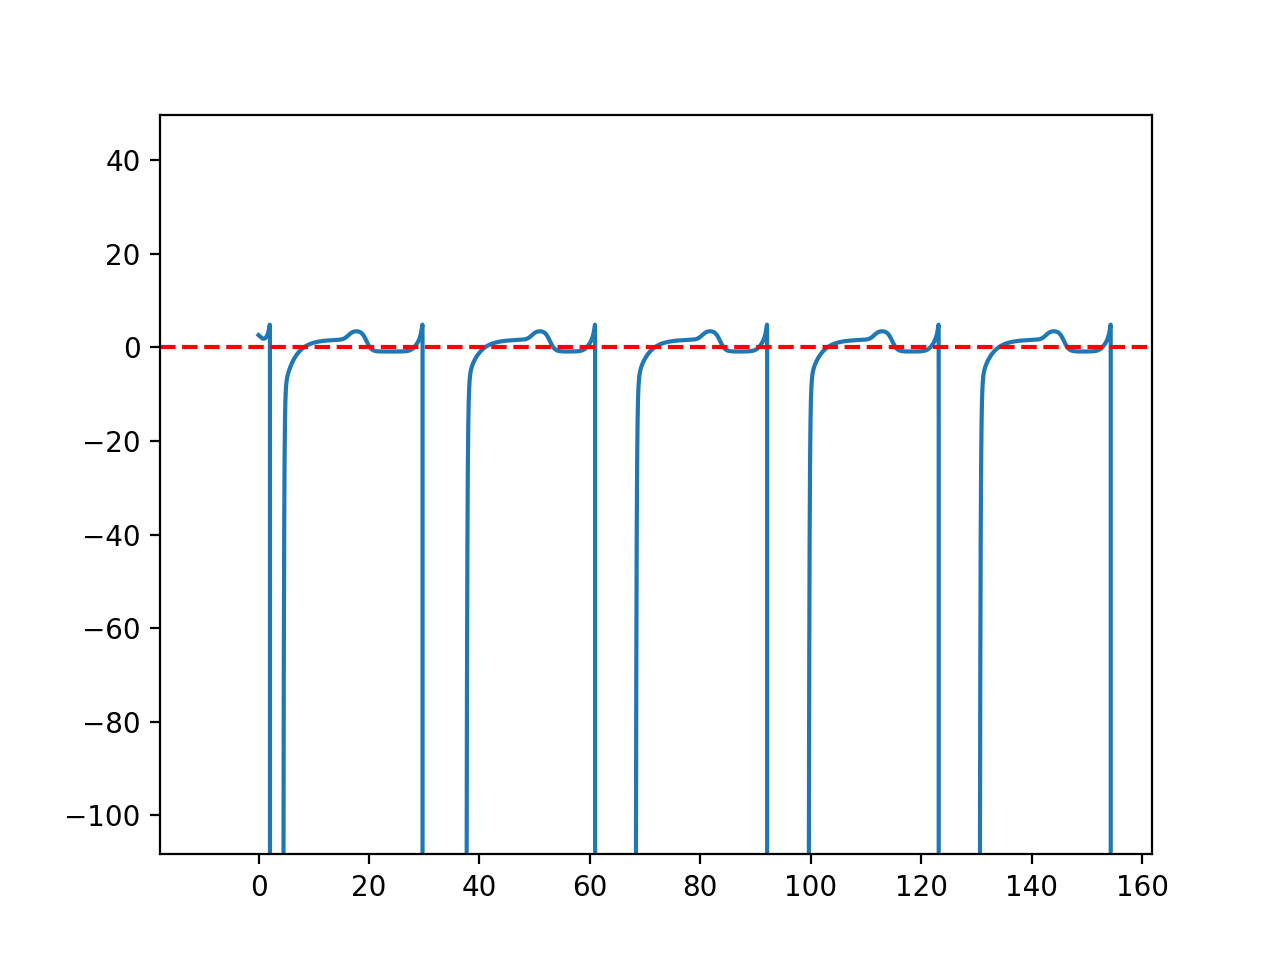

In [47]:
tr1 = (tr_ev1(R0, C0, P0))
%matplotlib notebook
plt.plot(tm, tr1)
plt.axhline(y=0, color='red', linestyle='--')

In [6]:
Cfp = sm.solve(Pdt, C) ##only dependent on parameters


Rfp = sm.solve(Rdt, R) ##dependent on fixed point of consumers
R30 = Rfp[0].subs(C,Cfp[0])
R31 = Rfp[1].subs(C,Cfp[0])
R32 = Rfp[2].subs(C,Cfp[0])


Pfp = sm.solve(Cdt, P) #dependent on fixed point of consumers & resources
Pfp[0]


(C*R*a_C*a_P*e_C*h_P - C*R*a_C*a_P*h_C*h_P*m_C - C*a_P*h_P*m_C + R*a_C*e_C - R*a_C*h_C*m_C - m_C)/(a_P*(R*a_C*h_C + 1))

In [16]:
R31

-(-a_C*h_C + q)/(2*a_C*h_C*q) - sqrt(a_C**2*h_C**2*r - 4*a_C**2*h_C*m_P*q/(a_P*(e_P - h_P*m_P)) + 2*a_C*h_C*q*r + q**2*r)/(2*a_C*h_C*q*sqrt(r))

In [7]:
##Function to extract eigen values#

def sym_eigen(tst):
    l = sm.Symbol('lambda')
    tst1 = tst - l*sm.eye(3)
    tst2 = tst1.det()*-1
    tst3 = sm.solve(tst2, l)
    return(tst3)

In [12]:
ids = np.arange(0, np.shape(par1)[1])
#ids = np.arange(0, 20)
for i in ids:
    
    r0 = par1[0][i]; q0 =  par1[1][i]
    aC0 = par1[2][i]; eC0 = par1[3][i]; mC0 = par1[4][i]; hC0 = par1[5][i]
    aP0 = par1[6][i]; eP0 = par1[7][i]; mP0 = par1[8][i]; hP0 = par1[9][i]
    
    #u0 = np.array([5000, 280, 58, 0]) - initial conditions used for simulations
    R0 = 5000; C0 = 280; P0 = 58;
    
    #Trace of the jacobian matrix
    traceu0 = traceM.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, R0),(C,C0),(P,P0)])
    
    
    #Find the eigen values of the jacobian
    
    #First step to get the fixed point values
    Cf = Cfp[0].subs([(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0)])
    
    Rf0 = 0
    Rf1 = R31.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0)])
    Rf2 = R32.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0)])
    
    Pf0 = Pfp[0].subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf0),(C,Cf)])
    Pf1 = Pfp[0].subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf1),(C,Cf)])
    Pf2 = Pfp[0].subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf2),(C,Cf)])
        
    
    Jss_val0 = Jss_val.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf0),(C,Cf),(P,Pf0)])
    Jss_val1 = Jss_val.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf1),(C,Cf),(P,Pf1)])
    Jss_val2 = Jss_val.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf2),(C,Cf),(P,Pf2)])
    
    ##TRace of the jacobian for 3 equi condns
    Tr0 = np.trace(Jss_val0)
    Tr1 = np.trace(Jss_val1)
    Tr2 = np.trace(Jss_val2)
    
    
    #Eigen values for 3 equi points
    eig0 = sym_eigen(Jss_val0)
    eig1 = sym_eigen(Jss_val1)
    eig2 = sym_eigen(Jss_val2)
    
    res = np.array([i, traceu0, Rf0, Cf, Pf0, Rf1, Cf, Pf1, Rf2, Cf, Pf2, Tr0, Tr1, Tr2, eig0[0], eig0[1], eig0[2], eig1[0], eig1[1], eig1[2], eig2[0], eig2[1], eig2[2]])
    res1 = np.reshape(res,[1, len(res)])
    res2 = pd.DataFrame(res1)
    
    with pd.ExcelWriter("stability_architypes.xlsx",mode="a",engine="openpyxl",if_sheet_exists="overlay") as writer:
        res2.to_excel(writer, sheet_name="Sheet1",header=None, startrow=writer.sheets["Sheet1"].max_row,index=False)
    #res2.to_csv('stability_architypes.csv', mode='a', index=False, header=False)
    #print(res)


In [137]:
res2.iloc[0]

0                                26
1                  7.81432524365668
2                                 0
3                  1.57518832704635
4                 -1.02454974070936
5                 -15.6611166433649
6                  1.57518832704635
7                 -3.44948461452667
8                  67112.2023128509
9                  1.57518832704635
10               -0.731727640209239
11                 4.84339366873604
12                -45.4585119381311
13                -5.50162629670698
14    -0.410741364285974 + 0.e-20*I
15     0.370756359634291 + 0.e-22*I
16      4.88337867338772 - 0.e-21*I
17     -46.5170584041114 + 0.e-20*I
18    -0.353730993217728 + 0.e-21*I
19      1.41227745919802 - 0.e-21*I
20       -5.473069231162 + 0.e-23*I
21    -0.344376918734811 + 0.e-22*I
22     0.315819853189828 - 0.e-22*I
Name: 0, dtype: object

In [57]:
Jss_val0 = Jss_val.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf0),(C,Cf),(P,Pf0)])
Jss_val1 = Jss_val.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf1),(C,Cf),(P,Pf1)])
Jss_val2 = Jss_val.subs([(r,r0),(q,q0),(aC,aC0),(eC,eC0),(mC,mC0),(hC,hC0),(aP,aP0),(eP,eP0),(mP,mP0),(hP,hP0),(R, Rf2),(C,Cf),(P,Pf2)])

np.trace(Jss_val2)

-1.55046874272693

In [61]:
Tr0 = np.trace(Jss_val0)
Tr1 = np.trace(Jss_val1)
Tr2 = np.trace(Jss_val2)

Tr0

1.55447340217405

In [91]:
eig0[0]

-0.0721522980228312 + 0.e-21*I

In [141]:
pip install openpyxl

     ------------------------------------ 242.1/242.1 kB 707.0 kB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
